In [1]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

import sys, os

sys.path.append("..")

from qmc_base import qmcSampler
from qmc_base import HaltonGenerator
from qmc_base import randomGenerator

In [2]:
def FtnOblate(theta_p, ratio):
    coeff = -.5 * ratio
    term1 = np.arcsinh(
        np.sqrt(-1 + ratio**2) * np.sin(theta_p)) / np.sqrt(-1 + ratio**2)
    term2 = np.sin(theta_p) * np.sqrt(1 + (-1 + ratio**2) * np.sin(theta_p)**2)
    return coeff * (term1 + term2)


def FtnOblateNormalized(theta_p, ratio):
    return FtnOblate(theta_p, ratio) / FtnOblate(np.pi / 2, ratio)


def FtnSpheroid(theta_p, ratio):
    coeff = -.5 * ratio
    term2 = np.sin(theta_p) * np.sqrt(1 + (-1 + ratio**2) * np.sin(theta_p)**2)
    if ratio > 1:
        term1 = np.arcsinh(
            np.sqrt(-1 + ratio**2) * np.sin(theta_p)) / np.sqrt(-1 + ratio**2)
        return coeff * (term1 + term2)

    if ratio < 1:
        term1 = np.arcsin(
            np.sqrt(1 - ratio**2) * np.sin(theta_p)) / np.sqrt(1 - ratio**2)
        return coeff * (term1 + term2)

    if ratio == 1:
        return np.sin(theta_p)


def FtnSpheroidNormalized(theta_p, ratio):
    return FtnSpheroid(theta_p, ratio) / FtnSpheroid(np.pi / 2, ratio)


def ToPolarAngle(u, ratio):
    return root(
        fun=lambda var_theta_p: FtnSpheroidNormalized(var_theta_p, ratio) - u,
        x0=0).x

In [3]:
qmc = qmcSampler(generator=HaltonGenerator, d=2, randomize=False)

In [4]:
nsamples = 1000

# spheroid parameters
a = 2.
b = 4.
ratio = b / a

# sampled spherical coordinates
u_list = 2 * qmc.sampleUniform(nsamples)[:, 0] - 1
phi_list = 2 * np.pi * qmc.sampleUniform(nsamples)[:, 1]
theta_list = np.array(
    [ToPolarAngle(u, ratio=ratio) + np.pi / 2 for u in u_list]).ravel()

# sampled Cartesian coordinates
x = b * np.sin(theta_list) * np.cos(phi_list)
y = b * np.sin(theta_list) * np.sin(phi_list)
z = a * np.cos(theta_list)

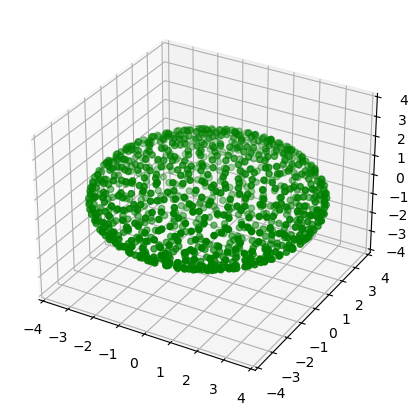

In [5]:
%matplotlib inline
# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(x, y, z, color="green")
ax.set_xlim((-max(a, b), max(a, b)))
ax.set_ylim((-max(a, b), max(a, b)))
ax.set_zlim((-max(a, b), max(a, b)))

# show plot
plt.show()

In [6]:
def sample_unit_sphere(n_sample, method='QMC'):
    '''  
    Generate n_sample position vectors

    Parameters
    ----------
    n_sample : integer
        number of stars to be generated

    Returns
    -------
    np.array with shape (n_star, 3)
        array contains (x,y,z) vector of each star

    '''

    if method == 'QMC':
        sampler = qmcSampler(generator=HaltonGenerator, d=2, randomize=False)
        samples = sampler.sampleUniform(n_samples=n_sample)
        nparray_u = samples[:, 0]
        nparray_v = samples[:, 1]
    elif method == 'random':
        nparray_u = np.random.uniform(0, 1, size=(n_sample, ))
        nparray_v = np.random.uniform(0, 1, size=(n_sample, ))
    else:
        raise NotImplementedError

    # polar angle
    nparray_phi = 2. * np.pi * nparray_u
    nparray_sin_phi = np.sin(nparray_phi)
    nparray_cos_phi = np.cos(nparray_phi)

    # azimuth angle
    nparray_cos_theta = 2. * nparray_v - 1.
    nparray_theta = np.arccos(nparray_cos_theta)
    nparray_sin_theta = np.sin(nparray_theta)

    # radial unit vector
    nparray_rhat = np.column_stack(
        (nparray_cos_phi * nparray_sin_theta,
         nparray_sin_phi * nparray_sin_theta, nparray_cos_theta))

    return nparray_rhat

In [7]:
def sample_ellipsoid(n_sample, ra, rb, rc, multiplier=1.5, method='QMC'):
    area_ratio_max = max(ra * rb, rb * rc, rc * ra)
    area_ratio_min = min(ra * rb, rb * rc, rc * ra)

    rejection_prob_min = area_ratio_min / area_ratio_max

    n_sample_gen = int(n_sample / rejection_prob_min * multiplier)

    arr_sphere = sample_unit_sphere(n_sample_gen, method=method)
    arr_area_ratio = np.sqrt((arr_sphere[:, 0] * rb * rc)**2 +
                             (ra * arr_sphere[:, 1] * rc)**2 +
                             (ra * rb * arr_sphere[:, 2])**2)
    arr_draw = np.random.random_sample(arr_sphere.shape[0])
    arr_mask = arr_draw < arr_area_ratio / area_ratio_max

    # rejection sampling
    arr_sphere = arr_sphere[arr_mask]
    if arr_sphere.shape[0] < n_sample:
        print(
            "WARNING: rejection sampling fails to generate {} samples. Please increase multiplier."
            .format(n_sample))
    else:
        arr_sphere = arr_sphere[:n_sample]

    # coordinate transformation to ellipsoid
    arr_r_axis = np.array([ra, rb, rc], dtype=arr_sphere.dtype)
    arr_ellipsoid = arr_sphere * arr_r_axis

    # normal
    arr_normal = arr_ellipsoid / arr_r_axis**2
    arr_normal = arr_normal / np.linalg.norm(arr_normal, axis=-1)[:,
                                                                  np.newaxis]
    #print(arr_ellipsoid[:2])
    #print(arr_normal[:2])
    return arr_ellipsoid, arr_normal

In [8]:
arr_ellipse, _ = sample_ellipsoid(1000, 4, 1, 2, method='QMC')

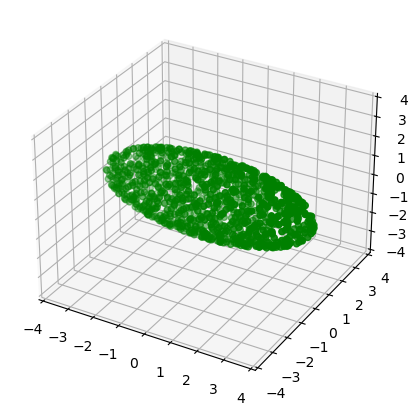

In [9]:
%matplotlib inline
# Import libraries
from mpl_toolkits import mplot3d

# Creating figure
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(arr_ellipse[:, 0],
             arr_ellipse[:, 1],
             arr_ellipse[:, 2],
             color="green")
ax.set_xlim((-max(a, b), max(a, b)))
ax.set_ylim((-max(a, b), max(a, b)))
ax.set_zlim((-max(a, b), max(a, b)))

# show plot
plt.show()